In [65]:
# Import dependencies
import json
import pandas as pd
import numpy as np
import re

In [66]:
# Directory for source data
file_dir = 'C:\\Users\\golfz\\Documents\\GitHub\\Movies-ETL'

In [67]:
# Read in source data JSON file from wikipedia movies
with open(f'{file_dir}\wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [68]:
# Check to see if the read was successful
len(wiki_movies_raw)

7311

In [69]:
# Read in keggle metadata from csv file
kaggle_metadata = pd.read_csv(f'{file_dir}\\movies_dataset\\movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}\\movies_dataset\\ratings.csv')

In [70]:
# Create dataframe from raw JSON data
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

In [71]:
# Create list of movies that have a director, link, and no value for 'No. of episodes'
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
len(wiki_movies)

7076

In [72]:
# Function to clean up data within a movie dictionary
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Arabic','Also known as','Cantonese','Chinese','French','Gwoyeu Romatzyh','Hangul','Hanyu Pinyin','Hebrew','Hokkien POJ','Japanese','Jyutping','Mandarin','McCune–Reischauer','Polish','Russian','Simplified','Simplified Chinese',                             'Traditional','Traditional Chinese','Wade–Giles','Yiddish','Literally','Original title','Revised Romanization','Romanized']:

        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)

    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles
        
    # Function to modify column name in movie dictionary
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    
    # Call change_column_name functions to merge/clean up column names
    change_column_name('Directed by', 'Director')
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')     

    return movie

In [73]:
# Call clean movies function for each movie in wiki_movies dictionary
clean_movies = [clean_movie(movie) for movie in wiki_movies]

In [74]:
# Overwrite the dataframe with the cleaned up movie data, show column list to verify
wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

['Animation by',
 'Audio format',
 'Based on',
 'Box office',
 'Budget',
 'Cinematography',
 'Color process',
 'Composer(s)',
 'Country',
 'Created by',
 'Director',
 'Distributor',
 'Editor(s)',
 'Executive producer(s)',
 'Followed by',
 'Genre',
 'Hepburn',
 'Label',
 'Language',
 'Narrated by',
 'Original language(s)',
 'Original network',
 'Picture format',
 'Preceded by',
 'Producer(s)',
 'Production company(s)',
 'Production location(s)',
 'Recorded',
 'Release date',
 'Running time',
 'Starring',
 'Suggested by',
 'Venue',
 'Voices of',
 'Writer(s)',
 'alt_titles',
 'imdb_link',
 'title',
 'url',
 'year']

In [75]:
# Extract imdb ID from imdb link using regular expression
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))

7076
7033


In [76]:
# Drop columns where values are more than 90% null
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [77]:
# Drop missing values from wiki_movies dataframe
box_office = wiki_movies_df['Box office'].dropna()

In [78]:
# Create a function to check if a value is not a string 
def is_not_a_string(x):
    return type(x) != str

# Check which rows in the box_office list are not strings
box_office[box_office.map(is_not_a_string)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [79]:
# Refactor the function as a lambda function and apply to box office list again
box_office[box_office.map(lambda x: type(x) != str)]

34                           [US$, 4,212,828]
54      [$6,698,361 (, United States, ), [2]]
74                    [$6,488,144, (US), [1]]
126                [US$1,531,489, (domestic)]
130                          [US$, 4,803,039]
                        ...                  
6980               [$99.6, million, [4], [5]]
6994                   [$365.6, million, [1]]
6995                         [$53.8, million]
7015                     [$435, million, [7]]
7048                   [$529.3, million, [4]]
Name: Box office, Length: 135, dtype: object

In [80]:
# Refactor to join lists into strings for those values in box office that are lists
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [81]:
# Replace any ranges with the second (high end) of the range
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [82]:
# Regular expression for match type #1 (ex: "$150 million")
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'

# Search box office data for a match
box_office.str.contains(form_one, flags=re.IGNORECASE).sum()

3909

In [83]:
# Regular expression for match type #2 (ex: "$150,000,000")
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'

# Search box office data for a match
box_office.str.contains(form_two, flags=re.IGNORECASE).sum()

1559

In [84]:
# Boolean series indicating which entries match each form
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)

In [85]:
# See if any entry does not match either form
box_office[~matches_form_one & ~matches_form_two]

600                      $5000 (US)
1070                     35,254,617
1480                     £3 million
1865                   ¥1.1 billion
2032                            N/A
2091                           $309
2665    926,423 admissions (France)
3631                            TBA
3879       CN¥3.650 million (China)
4116                     £7,385,434
4306                            $30
4561        $45.2k (only in Turkey)
5447                          £2.56
5784                       413 733$
6013                        Unknown
6369                          $111k
6370                           $588
6593                 less than $372
6843                        8 crore
Name: Box office, dtype: object

In [86]:
# This small number of remaining that do not match either form can be ignored.

In [87]:
box_office.str.extract(f'({form_one}|{form_two})')

,0
0,$21.4 million
1,$2.7 million
2,"$57,718,089"
3,"$7,331,647"
4,"$6,939,946"
...,...
7070,$19.4 million
7071,$41.9 million
7072,$76.1 million
7073,$38.4 million


In [88]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [89]:
# Extract and convert the box office revenues into numerical values
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [90]:
wiki_movies_df['box_office']

0       21400000.0
1        2700000.0
2       57718089.0
3        7331647.0
4        6939946.0
           ...    
7071    41900000.0
7072    76100000.0
7073    38400000.0
7074     5500000.0
7075           NaN
Name: box_office, Length: 7033, dtype: float64

In [91]:
# Drop the "Box Office" column since it is being replaced by "box_office"
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [92]:
# Create a budget series from the budget column in wiki movies dataframe
budget = wiki_movies_df['Budget'].dropna()

In [93]:
# Convert lists to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [94]:
# Remove values between $ and - for budgets given in ranges
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [95]:
# Apply the same form checks we used for the Box Office figures to see if there are any common forms that will not be caught by the parse function
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973             $34 [3] [4] million
1126               $120 [4] million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360               $150 [6] million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034              $$200 [4] million
5055           $155 [2] [3] million
5419                $40 [4] 

In [ ]:
# We need to clean up the values with citation indexes like "[3]" because the parse function does not apply to those.

In [96]:
# delete citation indexes from budget series (but leave value intact)
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

136                         Unknown
204     60 million Norwegian Kroner
478                         Unknown
973                     $34 million
1126                   $120 million
1226                        Unknown
1278                            HBO
1374                     £6,000,000
1397                     13 million
1480                   £2.8 million
1734                   CAD2,000,000
1913     PHP 85 million (estimated)
1948                    102,888,900
1953                   3,500,000 DM
1973                     ₤2,300,874
2281                     $14 milion
2451                     ₤6,350,000
3144                   € 40 million
3360                   $150 million
3418                        $218.32
3802                   £4.2 million
3906                            N/A
3959                    760,000 USD
4470                       19 crore
4641                    £17 million
5034                  $$200 million
5055                   $155 million
5419                    $40 

In [97]:
# Read the budget series into the parse_dollars function and write to budget column in df, then drop old "Budget" column
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [99]:
# Create a series of non-null values in release date column to assess what forms we can use to parse
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)
release_date

0                            July 11, 1990 ( 1990-07-11 )
1       May 17, 1990 ( 1990-05-17 ) (Cannes Film Marke...
2                          August 10, 1990 ( 1990-08-10 )
3                        December 25, 1990 ( 1990-12-25 )
4                                       December 19, 1990
                              ...                        
7071     December 25, 2018 ( 2018-12-25 ) (United States)
7072    December 11, 2018 ( 2018-12-11 ) ( Samuel Gold...
7073    November 8, 2018 ( 2018-11-08 ) ( AFI Fest ) D...
7074    August 31, 2018 ( 2018-08-31 ) ( Telluride ) D...
7075                      28 December 2018 ( 2018-12-28 )
Name: Release date, Length: 7001, dtype: object

In [129]:
# Four possible date forms
date_form_one = r'[a-zA-Z]+ [0-9]+, [0-9]{4}'
date_form_two = r'[0-9]{4}-[0-9]{2}-[0-9]{2}'
date_form_three = r'[a-zA-Z]+ [0-9]{4}'
date_form_four = r'[0-9]{4}'

In [130]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,"November 8, 2018"
7074,"August 31, 2018"


In [131]:
# Convert to date time using to_datetime pandas function
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [132]:
# Parse running time
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [133]:
# How many running time entries match the form "xxx minutes"
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE).sum()

6528

In [134]:
# For those that do not match that form, what form do they take?
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [135]:
# How many take the form "xxx m*"? (in other words, how many fit the more general form, including where minutes was abbreviates as min or min.?)
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE).sum()


6877

In [136]:
# What do the remaining forms look like?
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [137]:
# Parse running time for those with the form "x h x min" or similar
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [138]:
# Convert strings in running time series to numeric values
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [139]:
# Convert hours to minutes if minutes is zero
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [140]:
# Drop Running time since it has been replaced by running_time
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [142]:
# Check Kaggle Data Types
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [143]:
# Count number of each value in adult column
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

In [144]:
# Return values that are not False/True
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# Columns appear to be scrambled, so we will drop these entries, as well as any that are 'True' for adult column and drop the adult column since they will all be 'False' after dropping the corrupted and 'True' values
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [146]:
# Check data types in video column
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [147]:
# Convert the strings(objects) to boolean values
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [148]:
# Convert numeric columns
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [149]:
# Convert release_date to DateTime
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [150]:
# Inspect ratings data
ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [151]:
# inspect results if we were to convert timestamp to datetime 
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [152]:
# Dates above look reasonable, so we can apply the conversion to our actual column
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

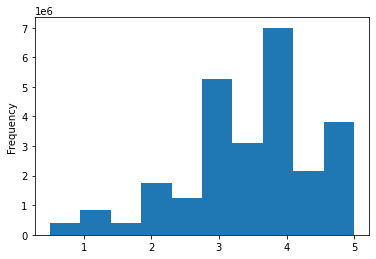

In [153]:
# Set formatting for floats, then show basic statistical data for ratings column using describe
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()